In [1]:
import sympy as sp
from sympy import latex
from sympy import solve
from sympy.physics.mechanics import dynamicsymbols

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import copernicusmarine
from scipy.integrate import cumulative_trapezoid as cumtrapz

import xarray as xr

In [2]:
t = dynamicsymbols._t


x, y, z, theta, phi = dynamicsymbols("x y z theta phi")  # x and y -> buoy coordinates

m_b, m_d, l, g = sp.symbols(
    "m_b m_d l g", positive=True
)  # mass buoy, mass drogue in [kg], wire length in [m], g in [m(s^2)]

k_b, k_d = sp.symbols("k_b k_d", positive=True)  # drag coefficients for buoy and drogue

U_b, V_b, U_d, V_d = sp.symbols(
    "U_b V_b U_d V_d", real=True
)  # surface horizontal velocities

# U_0, V_0 = sp.symbols('U_0 V_0', real = True) # surface horizontal velocities

In [3]:
lon0, lat0 = 54.6, 10.5  # largest variance of shear between 0 and 3m depth

time0 = np.datetime64("2009-04-08T23:58:00")

The buoy is fixed to the water surface and initially has no possibility of lifting off or being pushed/pulled underwater (z = 0). The position of the drogue is described in spherical coordinates depending on the position of the buoy.

In [4]:
r_b = sp.Matrix([x, y, 0])  # buoy position

r = l * sp.Matrix(
    [
        sp.sin(theta) * sp.cos(phi),
        sp.sin(theta) * sp.sin(phi),
        sp.cos(theta),
    ]
)

r_d = r_b + r  # drogue position

display(r_d)

Matrix([
[l*sin(theta(t))*cos(phi(t)) + x(t)],
[l*sin(phi(t))*sin(theta(t)) + y(t)],
[                   l*cos(theta(t))]])

u_b and u_d represent the flow velocities at the water surface and at the height of the drogue. Later, the flow velocity below the water surface will be implemented as a function of z.

In [5]:
# velocities

v_b = r_b.diff(t)
v_d = r_d.diff(t)

u_b = sp.Matrix([U_b, V_b, 0])
u_d = sp.Matrix([U_d, V_d, 0])

F_b and F_d describe the drag forces on the buoy and the drogue.

In [6]:
def _mag(vec):
    return sp.sqrt(vec.dot(vec))


F_b = -k_b * _mag(v_b - u_b) * (v_b - u_b)  # drag buoy with ext. velocity
F_d = -k_d * _mag(v_d - u_d) * (v_d - u_d)  # drag drogue with ext. velocity

In [7]:
# lagrangian

T = sp.Rational(1, 2) * m_b * v_b.dot(v_b) + sp.Rational(1, 2) * m_d * v_d.dot(
    v_d
)  # kinetic energy

V = m_d * g * r_d[2]  # potential energy

L = T - V  # lagrangian

Defining $q$, $\dot{q}$ and $\ddot{q}$

In [8]:
q = sp.Matrix([x, y, theta, phi])
qd = q.diff(t)
qdd = qd.diff(t)

Generalized forces: $\left(\begin{array}{c}
        \frac{\partial r}{\partial \theta} \cdot F \\
        \frac{\partial r}{\partial \phi} \cdot F
        \end{array}\right)$

In [9]:
Q = sp.Matrix([r_b.diff(qi).dot(F_b) + r_d.diff(qi).dot(F_d) for qi in q])

Q = sp.simplify(Q)

Equations of motion:    

$\frac{\partial}{\partial t} (\frac{\partial L}{\partial \dot{q}_j}) - \frac{\partial L}{\partial q_j} - Q_j = 0$

In [10]:
eoms = sp.Matrix(
    [L.diff(qdj).diff(t) - L.diff(qj) - Qj for qj, qdj, Qj in zip(q, qd, Q)]
)
eoms = sp.simplify(eoms)

steady_state = {
    theta.diff(t): 0,
    phi.diff(t): 0,

    x.diff(t, 2): 0,
    y.diff(t, 2): 0,
    theta.diff(t, 2): 0,
    phi.diff(t, 2): 0,
}

eoms_steady = sp.simplify(eoms.subs(steady_state))
display(eoms_steady)

Matrix([
[            -k_b*(U_b - Derivative(x(t), t))*sqrt((U_b - Derivative(x(t), t))**2 + (V_b - Derivative(y(t), t))**2) - k_d*(U_d - Derivative(x(t), t))*sqrt((U_d - Derivative(x(t), t))**2 + (V_d - Derivative(y(t), t))**2)],
[            -k_b*(V_b - Derivative(y(t), t))*sqrt((U_b - Derivative(x(t), t))**2 + (V_b - Derivative(y(t), t))**2) - k_d*(V_d - Derivative(y(t), t))*sqrt((U_d - Derivative(x(t), t))**2 + (V_d - Derivative(y(t), t))**2)],
[-l*(g*m_d*sin(theta(t)) + k_d*sqrt((U_d - Derivative(x(t), t))**2 + (V_d - Derivative(y(t), t))**2)*(U_d*cos(phi(t)) + V_d*sin(phi(t)) - sin(phi(t))*Derivative(y(t), t) - cos(phi(t))*Derivative(x(t), t))*cos(theta(t)))],
[                         k_d*l*sqrt((U_d - Derivative(x(t), t))**2 + (V_d - Derivative(y(t), t))**2)*(U_d*sin(phi(t)) - V_d*cos(phi(t)) - sin(phi(t))*Derivative(x(t), t) + cos(phi(t))*Derivative(y(t), t))*sin(theta(t))]])

In [11]:
solutions = solve(eoms_steady, U_d, U_b, theta, phi)

In [12]:
solution_0 = sp.simplify(solutions[0])
display(solution_0)

(-sqrt(-V_d**2 + 2*V_d*Derivative(y(t), t) - Derivative(y(t), t)**2) + Derivative(x(t), t), -sqrt(2)*sqrt(-V_b**2 + 2*V_b*Derivative(y(t), t) - sqrt(V_b**4 - 4*V_b**3*Derivative(y(t), t) + 6*V_b**2*Derivative(y(t), t)**2 - 4*V_b*Derivative(y(t), t)**3 + Derivative(y(t), t)**4) - Derivative(y(t), t)**2)/2 + Derivative(x(t), t), 0, phi(t))

In [13]:
M, F = sp.linear_eq_to_matrix(eoms, list(qdd))

In [14]:
M.shape, F.shape, qdd.shape

((4, 4), (4, 1), (4, 1))

In [15]:
par_syms = (m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d)

In [16]:
M_func = sp.lambdify(
    (t, x, y, theta, phi, *qd, m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d),
    M,
    modules="numpy",
)
F_func = sp.lambdify(
    (t, x, y, theta, phi, *qd, m_b, m_d, l, g, k_b, k_d, U_b, V_b, U_d, V_d),
    F,
    modules="numpy",
)

In [17]:
r_b_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms, r_b)
r_d_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms, r_d)

M_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms, M)
F_ = sp.lambdify((t,) + tuple(q) + tuple(qd) + par_syms, F)

In [18]:
par_dict = {m_b: 0.5, m_d: 0.5, l: 3.0, g: 9.81, k_b: 0.5, k_d: 2.0, U_b: 1.0, V_b: 2.0, U_d: 1.0, V_d: -0.5}
par_vals = tuple(par_dict[k] for k in par_syms)

In [19]:
def rhs(t_num, y, parameter_values=par_vals):

    q_num = y[:4]
    qd_num = y[4:]

    th = q_num[2]
    length = parameter_values[2]

    x_b, y_b, th, ph = q_num

    U_b0, V_b0, U_d0, V_d0 = par_vals[-4:]

    z_d = float(max(0.0, length * np.cos(th)))

    U_b, V_b, U_d, V_d = U_b0, V_b0, U_d0, V_d0

    dyn_params = parameter_values

    M_num = np.array(M_func(t_num, *q_num, *qd_num, *dyn_params), dtype=float)
    F_num = np.array(F_func(t_num, *q_num, *qd_num, *dyn_params), dtype=float).reshape(
        -1
    )

    qdd_num = np.linalg.solve(M_num, F_num)

    return np.concatenate([qd_num, qdd_num])

In [20]:
q0 = np.array([0.0, 0.0, 3 * np.pi / 4, 0.0])  # x, y, theta, phi
qd0 = np.array([0.0, 0.0, 0.0, 0.0])
y0 = np.concatenate([q0, qd0])

t_span = (0.0, 30.0)
t_eval = np.arange(t_span[0], t_span[1], 1.0)

In [21]:
sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, atol=1e-3, rtol=1e-3, method="RK23")
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+00 ...  2.800e+01  2.900e+01]
        y: [[ 0.000e+00  1.705e+00 ...  2.921e+01  3.021e+01]
            [ 0.000e+00  7.391e-01 ...  9.658e+00  9.991e+00]
            ...
            [ 0.000e+00  2.153e-01 ...  1.316e-03  4.044e-03]
            [ 0.000e+00 -1.955e+00 ...  5.912e-16 -5.208e-15]]
      sol: None
 t_events: None
 y_events: None
     nfev: 266
     njev: 0
      nlu: 0

In [22]:
t = sol.t
x_p0 = float(sol.y[0, 0])
y_p0 = float(sol.y[1, 0])

U_series = []
V_series = []
for i in range(len(t)):
    x_i = float(sol.y[0, i])
    y_i = float(sol.y[1, i])
    U_b0, V_b0, U_d0, V_d0 = par_vals[-4:]
    U_series.append(U_b)
    V_series.append(V_b)

U_series = np.asarray(U_series)
V_series = np.asarray(V_series)

x_p = x_p0 + np.concatenate(([0.0], cumtrapz(U_series, t)))
y_p = y_p0 + np.concatenate(([0.0], cumtrapz(V_series, t)))
z_p = np.zeros_like(t)

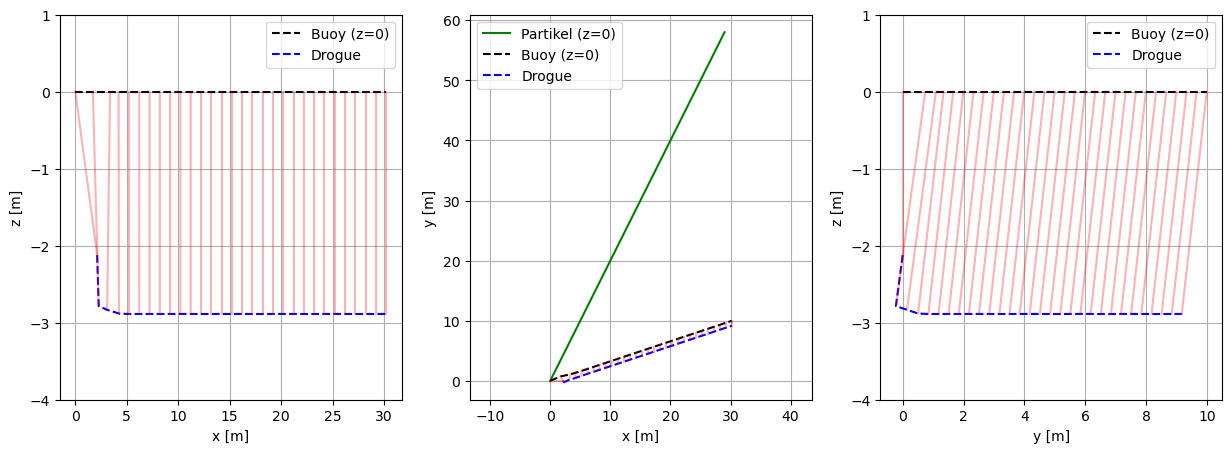

In [27]:
# x-z

r_b_traj_proj = []
r_d_traj_proj = []
for i, ti in enumerate(sol.t):

    q_num = sol.y[:4]
    qd_num = sol.y[4:]

    th = float(sol.y[2, i])
    length = par_vals[2]

    U_b0, V_b0, U_d0, V_d0 = map(float, par_vals[-4:])

    x_b = float(sol.y[0, i])
    y_b = float(sol.y[1, i])
    th = float(sol.y[2, i])

    U_b, V_b, U_d, V_d = U_b0, V_b0, U_d0, V_d0

    rb = np.array(
        r_b_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals)),
        dtype=float,
    ).reshape(-1)
    rd = np.array(
        r_d_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals)),
        dtype=float,
    ).reshape(-1)
    r_b_traj_proj.append([rb[0], rb[2]])
    r_d_traj_proj.append([rd[0], rd[2]])

r_b_traj_proj = np.array(r_b_traj_proj)
r_d_traj_proj = np.array(r_d_traj_proj)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(r_b_traj_proj[:, 0], r_b_traj_proj[:, 1], "k--", label="Buoy (z=0)")
ax1.plot(r_d_traj_proj[:, 0], r_d_traj_proj[:, 1], "b--", label="Drogue")

step = max(1, len(sol.t) // 30)
for i in range(0, len(sol.t), step):
    ax1.plot(
        [r_b_traj_proj[i, 0], r_d_traj_proj[i, 0]],
        [r_b_traj_proj[i, 1], r_d_traj_proj[i, 1]],
        color="red",
        alpha=0.3,
    )

x_min = min(r_b_traj_proj[:, 0].min(), r_d_traj_proj[:, 0].min())
x_max = max(r_b_traj_proj[:, 0].max(), r_d_traj_proj[:, 0].max())

ax1.set_xlabel("x [m]")
ax1.set_ylabel("z [m]")
ax1.grid(True)
ax1.legend()

# -------------------------------------------------------------------------------------------------------

# x-y

r_b_traj_proj = []
r_d_traj_proj = []
for i, ti in enumerate(sol.t):

    q_num = sol.y[:4]
    qd_num = sol.y[4:]

    th = float(sol.y[2, i])
    length = par_vals[2]

    U_b0, V_b0, U_d0, V_d0 = map(float, par_vals[-4:])

    x_b = float(sol.y[0, i])
    y_b = float(sol.y[1, i])
    th = float(sol.y[2, i])

    U_b, V_b, U_d, V_d = U_b0, V_b0, U_d0, V_d0

    rb = np.array(
        r_b_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals)),
        dtype=float,
    ).reshape(-1)
    rd = np.array(
        r_d_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals)),
        dtype=float,
    ).reshape(-1)
    r_b_traj_proj.append([rb[0], rb[1]])
    r_d_traj_proj.append([rd[0], rd[1]])

r_b_traj_proj = np.array(r_b_traj_proj)
r_d_traj_proj = np.array(r_d_traj_proj)

x_p0 = float(sol.y[0, 0])
y_p0 = float(sol.y[1, 0])
U_series = np.full_like(sol.t, U_b0, dtype=float)
V_series = np.full_like(sol.t, V_b0, dtype=float)
x_p = x_p0 + np.concatenate(([0.0], cumtrapz(U_series, sol.t)))
y_p = y_p0 + np.concatenate(([0.0], cumtrapz(V_series, sol.t)))

ax2.plot(x_p, y_p, "g-", lw=1.5, label="Partikel (z=0)")
ax2.plot(r_b_traj_proj[:, 0], r_b_traj_proj[:, 1], "k--", label="Buoy (z=0)")
ax2.plot(r_d_traj_proj[:, 0], r_d_traj_proj[:, 1], "b--", label="Drogue")

step = max(1, len(sol.t) // 30)
for i in range(0, len(sol.t), step):
    ax2.plot(
        [r_b_traj_proj[i, 0], r_d_traj_proj[i, 0]],
        [r_b_traj_proj[i, 1], r_d_traj_proj[i, 1]],
        color="red",
        alpha=0.3,
    )

x_min = min(r_b_traj_proj[:, 0].min(), r_d_traj_proj[:, 0].min())
x_max = max(r_b_traj_proj[:, 0].max(), r_d_traj_proj[:, 0].max())

ax2.set_xlabel("x [m]")
ax2.set_ylabel("y [m]")
ax2.grid(True)
ax2.legend()
ax2.axis("equal")

# -------------------------------------------------------------------------------------------------------

# y-z

r_b_traj_proj = []
r_d_traj_proj = []
for i, ti in enumerate(sol.t):

    q_num = sol.y[:4]
    qd_num = sol.y[4:]

    th = float(sol.y[2, i])
    length = par_vals[2]

    U_b0, V_b0, U_d0, V_d0 = map(float, par_vals[-4:])  # <-- FIX (floats!)

    x_b = float(sol.y[0, i])
    y_b = float(sol.y[1, i])

    U_b, V_b, U_d, V_d = U_b0, V_b0, U_d0, V_d0

    rb = np.array(
        r_b_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals)),
        dtype=float,
    ).reshape(-1)
    rd = np.array(
        r_d_(*(ti, *sol.y[:4, i], *sol.y[4:, i], *par_vals)),
        dtype=float,
    ).reshape(-1)
    r_b_traj_proj.append([rb[1], rb[2]])
    r_d_traj_proj.append([rd[1], rd[2]])

r_b_traj_proj = np.array(r_b_traj_proj)
r_d_traj_proj = np.array(r_d_traj_proj)

ax3.plot(r_b_traj_proj[:, 0], r_b_traj_proj[:, 1], "k--", label="Buoy (z=0)")
ax3.plot(r_d_traj_proj[:, 0], r_d_traj_proj[:, 1], "b--", label="Drogue")

step = max(1, len(sol.t) // 30)
for i in range(0, len(sol.t), step):
    ax3.plot(
        [r_b_traj_proj[i, 0], r_d_traj_proj[i, 0]],
        [r_b_traj_proj[i, 1], r_d_traj_proj[i, 1]],
        color="red",
        alpha=0.3,
    )

x_min = min(r_b_traj_proj[:, 0].min(), r_d_traj_proj[:, 0].min())
x_max = max(r_b_traj_proj[:, 0].max(), r_d_traj_proj[:, 0].max())

ax3.set_xlabel("y [m]")
ax3.set_ylabel("z [m]")
ax3.grid(True)
ax3.legend()

ax1.set_ylim(-4, 1)
ax3.set_ylim(-4, 1)

plt.savefig('3', dpi = 300, bbox_inches = 'tight')




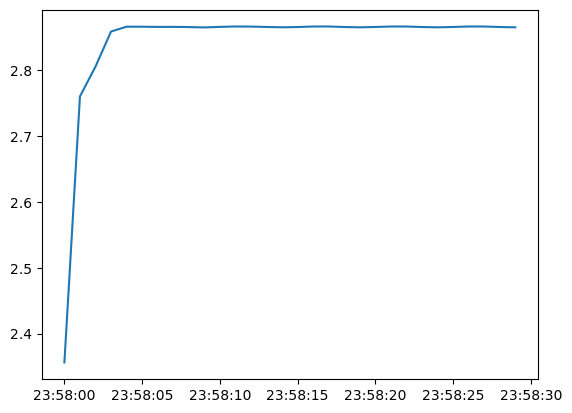

In [24]:
plt.plot(time0 + sol.t * np.timedelta64(1, "s"), sol.y[2, :])

In [25]:
theta_mean = np.mean(sol.y[2, sol.t > (sol.t[-1] - 5)])  # mean for the last few seconds
phi_mean = np.mean(sol.y[3, sol.t > (sol.t[-1] - 5)])

print(round(np.degrees(theta_mean), 3))  # theta
print(round(np.degrees(phi_mean), 3))  # phi

164.189
-90.0
